# Representation Learning


In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import tarfile
import glob
from datetime import datetime
import math
import csv
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from tqdm import tqdm
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, average_precision_score, silhouette_score, adjusted_rand_score
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split

In [7]:
# Load data
# Training set (Set A)
df_train = pd.read_parquet('final-data/final-set-a.parquet')
df_train = df_train.fillna(0)  # Replace NaN with 0 if any remain

# Validation set (Set B) - for hyperparameter tuning
df_val = pd.read_parquet('final-data/final-set-b.parquet')
df_val = df_val.fillna(0)
if 'ICUType' in df_val.columns:
        print("Removing ICUType column as requested")
        df_val = df_val.drop(columns=['ICUType'])

Removing ICUType column as requested


In [8]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 196000 entries, 0 to 195999
Data columns (total 42 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Time         196000 non-null  int64  
 1   Age          196000 non-null  float64
 2   BUN          196000 non-null  float64
 3   Creatinine   196000 non-null  float64
 4   GCS          196000 non-null  float64
 5   Gender       196000 non-null  float64
 6   Glucose      196000 non-null  float64
 7   HCO3         196000 non-null  float64
 8   HCT          196000 non-null  float64
 9   HR           196000 non-null  float64
 10  Height       196000 non-null  float64
 11  K            196000 non-null  float64
 12  Mg           196000 non-null  float64
 13  NIDiasABP    196000 non-null  float64
 14  NIMAP        196000 non-null  float64
 15  NISysABP     196000 non-null  float64
 16  Na           196000 non-null  float64
 17  Platelets    196000 non-null  float64
 18  RecordID     196000 non-

### Q3.1 Pretraining and Linear Probes (4 pts)

We pre-train an autoencoder consisting of the classical encoder-decoder architecture, and compare with the RNN / LSTM approach in question 2.2.

In [9]:
def prepare_sequence_data(df):
    """
    Convert dataframe to sequence format grouped by RecordID.
    Returns a dictionary mapping RecordID to the sequential ICU data.
    """
    patient_sequences = {}
    
    for record_id, group in df.groupby('RecordID'):
        # Sort by timestamp to ensure temporal order
        group = group.sort_values('Time')
        
        # Get features - excluding RecordID and Time
        features = group.drop(['RecordID', 'Time'], axis=1).values
        
        patient_sequences[record_id] = features
    
    return patient_sequences

In [10]:
def create_tensor_dataset(patient_sequences):
    """
    Create a PyTorch TensorDataset from patient sequences.
    """
    sequences = []
    record_ids = []
    
    for record_id, sequence in patient_sequences.items():
        sequences.append(sequence)
        record_ids.append(record_id)
    
    # Convert to tensors
    sequences_tensor = torch.FloatTensor(np.array(sequences))
    record_ids_tensor = torch.LongTensor(np.array(record_ids))
    
    return TensorDataset(sequences_tensor, record_ids_tensor)

In [11]:
# Prepare data
train_sequences = prepare_sequence_data(df_train)
val_sequences = prepare_sequence_data(df_val)

# Create datasets, dataloaders
train_dataset = create_tensor_dataset(train_sequences)
val_dataset = create_tensor_dataset(val_sequences)
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

Note that the patient's time series data consisted of 49 time stemps * 40 features (excluding ICUType), so 1960-dimensional data, which we represent in a latent space of dimension 32.

In [35]:
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim=128, embedding_dim=20):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_dim * 2, embedding_dim)  # *2 for bidirectional
    
    def forward(self, x):
        # x shape: [batch_size, seq_length, features]
        output, (hidden, _) = self.lstm(x)
        
        # For bidirectional LSTM, concatenate the last hidden states from both directions
        hidden_cat = torch.cat((hidden[-2], hidden[-1]), dim=1)
        
        # Project to embedding dimension
        embedding = self.fc(hidden_cat)
        return embedding

In [36]:
class Decoder(nn.Module):
    def __init__(self, embedding_dim, hidden_dim=128, output_dim=40):
        super().__init__()
        self.fc = nn.Linear(embedding_dim, hidden_dim)
        self.lstm = nn.LSTM(hidden_dim, hidden_dim, batch_first=True)
        self.output_layer = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, embedding, seq_length):
        # embedding shape: [batch_size, embedding_dim]
        # Transform embedding to hidden state
        hidden = self.fc(embedding).unsqueeze(0)  # [1, batch_size, hidden_dim]
        
        # Initialize cell state
        cell = torch.zeros_like(hidden)
        
        # Repeat the hidden state as input for each time step
        decoder_input = hidden.permute(1, 0, 2).repeat(1, seq_length, 1)
        
        # Pass through LSTM
        output, _ = self.lstm(decoder_input, (hidden, cell))
        
        # Project to output dimension
        reconstructed = self.output_layer(output)
        return reconstructed

In [37]:
class TimeSeriesAutoencoder(nn.Module):
    def __init__(self, input_dim, hidden_dim=128, embedding_dim=20):
        super().__init__()
        self.encoder = Encoder(input_dim, hidden_dim, embedding_dim)
        self.decoder = Decoder(embedding_dim, hidden_dim, input_dim)
    
    def forward(self, x):
        seq_length = x.size(1)
        # Encode
        embedding = self.encoder(x)
        
        # Decode
        reconstructed = self.decoder(embedding, seq_length)
        
        return reconstructed, embedding

In [38]:
# Verify features dimension
input_dim= train_dataset[0][0].shape[1]  
print("Features dimension train: ", input_dim)

input_dim_val = val_dataset[0][0].shape[1]  
print("Features dimension val: ", input_dim_val)

Features dimension train:  40
Features dimension val:  40


100%|██████████| 125/125 [00:06<00:00, 19.27it/s]


Epoch 1/75, Train Loss: 0.481194, Val Loss: 0.837318


100%|██████████| 125/125 [00:05<00:00, 21.96it/s]


Epoch 2/75, Train Loss: 0.369595, Val Loss: 0.802597


100%|██████████| 125/125 [00:05<00:00, 22.16it/s]


Epoch 3/75, Train Loss: 0.328354, Val Loss: 0.780142


100%|██████████| 125/125 [00:05<00:00, 21.98it/s]


Epoch 4/75, Train Loss: 0.306236, Val Loss: 0.776309


100%|██████████| 125/125 [00:05<00:00, 22.42it/s]


Epoch 5/75, Train Loss: 0.290196, Val Loss: 0.762525


100%|██████████| 125/125 [00:05<00:00, 22.05it/s]


Epoch 6/75, Train Loss: 0.275093, Val Loss: 0.750671


100%|██████████| 125/125 [00:05<00:00, 22.57it/s]


Epoch 7/75, Train Loss: 0.264931, Val Loss: 0.745129


100%|██████████| 125/125 [00:05<00:00, 22.68it/s]


Epoch 8/75, Train Loss: 0.256094, Val Loss: 0.739290


100%|██████████| 125/125 [00:05<00:00, 22.72it/s]


Epoch 9/75, Train Loss: 0.248526, Val Loss: 0.736928


100%|██████████| 125/125 [00:05<00:00, 22.62it/s]


Epoch 10/75, Train Loss: 0.243466, Val Loss: 0.732121


100%|██████████| 125/125 [00:06<00:00, 18.80it/s]


Epoch 11/75, Train Loss: 0.238332, Val Loss: 0.733331


100%|██████████| 125/125 [00:05<00:00, 22.71it/s]


Epoch 12/75, Train Loss: 0.237068, Val Loss: 0.730045


100%|██████████| 125/125 [00:05<00:00, 22.39it/s]


Epoch 13/75, Train Loss: 0.233137, Val Loss: 0.724380


100%|██████████| 125/125 [00:05<00:00, 22.66it/s]


Epoch 14/75, Train Loss: 0.230549, Val Loss: 0.734475


100%|██████████| 125/125 [00:05<00:00, 22.25it/s]


Epoch 15/75, Train Loss: 0.232943, Val Loss: 0.727752


100%|██████████| 125/125 [00:05<00:00, 23.12it/s]


Epoch 16/75, Train Loss: 0.229727, Val Loss: 0.728197


100%|██████████| 125/125 [00:05<00:00, 22.77it/s]


Epoch 17/75, Train Loss: 0.226307, Val Loss: 0.723597


100%|██████████| 125/125 [00:05<00:00, 22.54it/s]


Epoch 18/75, Train Loss: 0.221839, Val Loss: 0.728489


100%|██████████| 125/125 [00:05<00:00, 22.69it/s]


Epoch 19/75, Train Loss: 0.220231, Val Loss: 0.727955


100%|██████████| 125/125 [00:05<00:00, 23.18it/s]


Epoch 20/75, Train Loss: 0.220240, Val Loss: 0.728121


100%|██████████| 125/125 [00:05<00:00, 22.09it/s]


Epoch 21/75, Train Loss: 0.218243, Val Loss: 0.725301


100%|██████████| 125/125 [00:05<00:00, 22.85it/s]


Epoch 22/75, Train Loss: 0.220154, Val Loss: 0.729379
Early stopping after 22 epochs


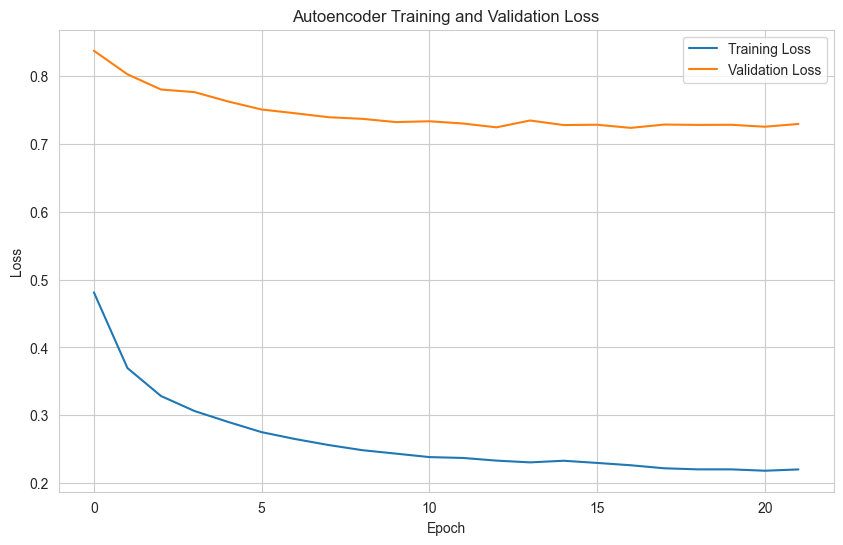

<All keys matched successfully>

In [39]:
# Initialize model and optimization
hidden_dim = 128
embedding_dim = 20
autoencoder = TimeSeriesAutoencoder(input_dim, hidden_dim, embedding_dim)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
autoencoder = autoencoder.to(device)

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)

# Training loop
num_epochs = 75
train_losses = []
val_losses = []

# Early stopping parameters
patience = 5
best_val_loss = float('inf')
patience_counter = 0


for epoch in range(num_epochs):
    # Training
    autoencoder.train()
    epoch_loss = 0
    
    for batch_idx, (data, _) in enumerate(tqdm(train_loader)):
        data = data.to(device)
        
        # Forward pass
        reconstructed, _ = autoencoder(data)
        loss = criterion(reconstructed, data)
        
        # Backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
    
    avg_train_loss = epoch_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    
    # Validation
    autoencoder.eval()
    val_loss = 0
    
    with torch.no_grad():
        for data, _ in val_loader:
            data = data.to(device)
            reconstructed, _ = autoencoder(data)
            loss = criterion(reconstructed, data)
            val_loss += loss.item()
    
    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    
    # Print progress
    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.6f}, Val Loss: {avg_val_loss:.6f}')
    
    # Early stopping
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0
        # Save best model
        torch.save(autoencoder.state_dict(), 'embedding_autoencoder/best_autoencoder.pth')
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f'Early stopping after {epoch+1} epochs')
            break

# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Autoencoder Training and Validation Loss')
plt.legend()
plt.savefig('embedding_autoencoder/autoencoder_loss.png')
plt.show()

# Load the best model
autoencoder.load_state_dict(torch.load('embedding_autoencoder/best_autoencoder.pth'))

In [40]:
# Function to generate embeddings for all patients
def generate_embeddings(model, dataloader, device):
    model.eval()
    embeddings = []
    record_ids = []
    
    with torch.no_grad():
        for data, ids in dataloader:
            data = data.to(device)
            _, embedding = model(data)
            
            embeddings.append(embedding.cpu().numpy())
            record_ids.extend(ids.numpy())
    
    # Concatenate all embeddings
    embeddings = np.vstack(embeddings)
    
    # Create a dictionary mapping record_id to embedding
    embedding_dict = {record_id: emb for record_id, emb in zip(record_ids, embeddings)}
    
    return embedding_dict

# Generate embeddings, save them
train_embedding_dict = generate_embeddings(autoencoder, train_loader, device)
val_embedding_dict = generate_embeddings(autoencoder, val_loader, device)

embedding_df_train = pd.DataFrame.from_dict(train_embedding_dict, orient='index')
embedding_df_train.index.name = 'RecordID'
embedding_df_train.to_csv('embedding_autoencoder/train_embeddings.csv')

embedding_df_val = pd.DataFrame.from_dict(val_embedding_dict, orient='index')
embedding_df_val.index.name = 'RecordID'
embedding_df_val.to_csv('embedding_autoencoder/val_embeddings.csv')

Autoencoder training complete and embeddings generated!


Linear Probe evaluation

In [41]:
# Load outcomes data, extract the in-hospital mortality labels
outcomes_train = pd.read_parquet('processed-data/processed-outcomes-a.parquet')  
outcomes_val = pd.read_parquet('processed-data/processed-outcomes-b.parquet')    
outcomes_test = pd.read_parquet('processed-data/processed-outcomes-c.parquet')  
train_labels = outcomes_train.set_index('RecordID')['In-hospital_death']
val_labels = outcomes_val.set_index('RecordID')['In-hospital_death']
test_labels = outcomes_test.set_index('RecordID')['In-hospital_death']

# Prepare data for linear probe, merge embeddings with labels
train_data = embedding_df_train.join(train_labels, how='inner')
val_data = embedding_df_val.join(val_labels, how='inner')

# Split features and labels
X_train = train_data.drop('In-hospital_death', axis=1)
y_train = train_data['In-hospital_death']

X_val = val_data.drop('In-hospital_death', axis=1)
y_val = val_data['In-hospital_death']

C=0.001, Validation AuROC: 0.4767, Validation AuPRC: 0.1477
C=0.01, Validation AuROC: 0.4816, Validation AuPRC: 0.1501
C=0.1, Validation AuROC: 0.4784, Validation AuPRC: 0.1481
C=1, Validation AuROC: 0.4770, Validation AuPRC: 0.1470
C=10, Validation AuROC: 0.4768, Validation AuPRC: 0.1468
C=100, Validation AuROC: 0.4768, Validation AuPRC: 0.1468
Best validation AuROC: 0.4816
Removing ICUType column as requested
Test AuROC: 0.5494
Test AuPRC: 0.1934


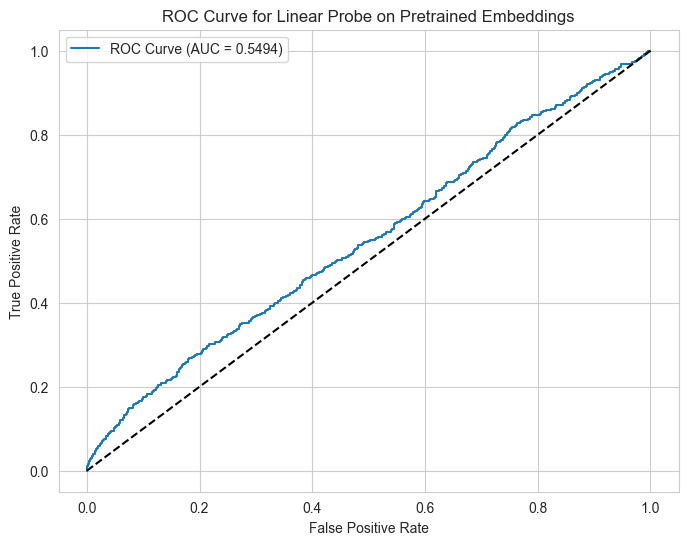

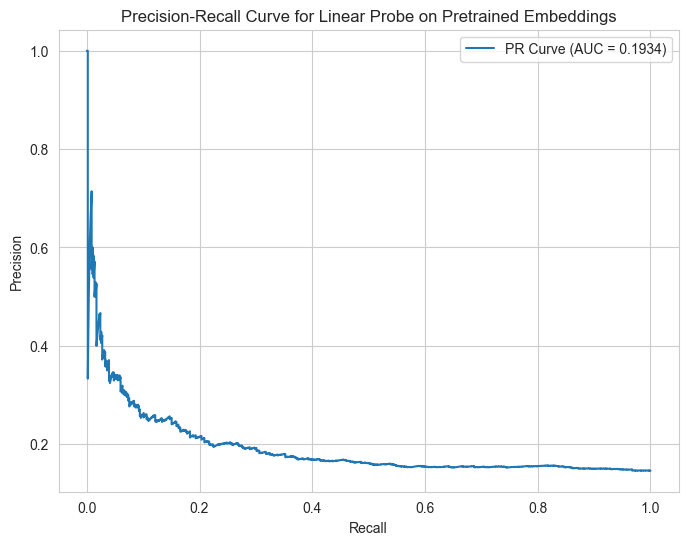

In [42]:
# Logistic Regression with different regularization strengths
C_values = [0.001, 0.01, 0.1, 1, 10, 100]
best_val_auc = 0
best_model = None

for C in C_values:
    # Train model
    model = LogisticRegression(C=C, max_iter=1000, random_state=42)
    model.fit(X_train, y_train)
    
    # Evaluate on validation set
    val_probs = model.predict_proba(X_val)[:, 1]
    val_auc = roc_auc_score(y_val, val_probs)
    val_auprc = average_precision_score(y_val, val_probs)
    
    print(f"C={C}, Validation AuROC: {val_auc:.4f}, Validation AuPRC: {val_auprc:.4f}")
    
    # Save best model
    if val_auc > best_val_auc:
        best_val_auc = val_auc
        best_model = model

print(f"Best validation AuROC: {best_val_auc:.4f}")

# Now evaluate on test set
# First, load test data
df_test = pd.read_parquet('final-data/final-set-c.parquet')
df_test = df_test.fillna(0)
if 'ICUType' in df_test.columns:
        print("Removing ICUType column as requested")
        df_test = df_test.drop(columns=['ICUType'])

# Prepare test data
test_sequences = prepare_sequence_data(df_test)
test_dataset = create_tensor_dataset(test_sequences)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Generate embeddings for test set
test_embedding_dict = generate_embeddings(autoencoder, test_loader, device)
embedding_df_test = pd.DataFrame.from_dict(test_embedding_dict, orient='index')
embedding_df_test.index.name = 'RecordID'

# Merge with labels
test_data = embedding_df_test.join(test_labels, how='inner')
X_test = test_data.drop('In-hospital_death', axis=1)
y_test = test_data['In-hospital_death']

# Make predictions
test_probs = best_model.predict_proba(X_test)[:, 1]

# Calculate metrics
test_auc = roc_auc_score(y_test, test_probs)
test_auprc = average_precision_score(y_test, test_probs)

print(f"Test AuROC: {test_auc:.4f}")
print(f"Test AuPRC: {test_auprc:.4f}")

# Plot ROC curve
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

fpr, tpr, _ = roc_curve(y_test, test_probs)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {test_auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Linear Probe on Pretrained Embeddings')
plt.legend()
plt.savefig('embedding_autoencoder/roc_curve.png')
plt.show()

# Plot Precision-Recall curve
from sklearn.metrics import precision_recall_curve

precision, recall, _ = precision_recall_curve(y_test, test_probs)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'PR Curve (AUC = {test_auprc:.4f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Linear Probe on Pretrained Embeddings')
plt.legend()
plt.savefig('embedding_autoencoder/pr_curve.png')
plt.show()

### Q3.2 Simulate label scarcity (4 pts)

In this subquestion, we would like to answer the question how unsupervised representations may help to increase prediction performance in the limited labeled data scenario. We anticipate that when labels are scarce, the model trained using time-series representations as input features outperforms the end-to-end supervised model, confirming the benefit of unsupervised representation learning in limited data settings. Also, the question is if using all labeled samples available to train a more complex classifier, does the best unsupervised representations still lead to a better performance than supervised representations? For all models, however, performance might also not saturate when increasing the training set size, which would indicate that the entire regime is data scarce. Given more data, the purely supervised models might eventually surpass the ones using learned representations.

Part i): Train three different supervised (as in Q2.x) models with the same (or as similar as possible) architecture as your pretrained network, but only use 100, 500, and 1000 patients from the training set and report your full test set performance (2 pts).

Part ii): Train three linear probes (as in Q3.1 step 2) using only 100, 500, 1000 labelled patients and report the full test set C performance. (2 pts).

In [49]:
# Assuming you have:
# - embedding_df_train: DataFrame with embeddings for training set (from set A)
# - train_labels: Series with labels for training set (from set A)
# - X_test, y_test: Test data embeddings and labels (from set C)

def train_linear_probe_with_limited_data(X_train, y_train, X_test, y_test, n_samples):
    """
    Train a logistic regression model using only n_samples labeled examples
    """
    
    # Randomly sample n patients, use stratified sampling to maintain class imbalance
    _, X_sampled, _, y_sampled = train_test_split(
        X_train, y_train, 
        test_size=n_samples/len(y_train),
        stratify=y_train,
        random_state=42
    )
        
    print(f"Training with {len(y_sampled)} samples")
    print(f"Class distribution: {y_sampled.value_counts().to_dict()}")
    
    # Train logistic regression
    model = LogisticRegression(C=1.0, max_iter=1000, random_state=42)
    model.fit(X_sampled, y_sampled)
    
    # Evaluate on test set
    test_probs = model.predict_proba(X_test)[:, 1]
    test_auc = roc_auc_score(y_test, test_probs)
    test_auprc = average_precision_score(y_test, test_probs)
    
    return model, test_auc, test_auprc


Training with 100 labeled samples:
Training with 100 samples
Class distribution: {0: 86, 1: 14}
Test AuROC: 0.6246
Test AuPRC: 0.2361

Training with 500 labeled samples:
Training with 500 samples
Class distribution: {0: 431, 1: 69}
Test AuROC: 0.5866
Test AuPRC: 0.2192

Training with 1000 labeled samples:
Training with 1000 samples
Class distribution: {0: 862, 1: 138}
Test AuROC: 0.5778
Test AuPRC: 0.2155

Results summary:
   n_samples     AuROC     AuPRC
0        100  0.624611  0.236142
1        500  0.586600  0.219175
2       1000  0.577798  0.215515


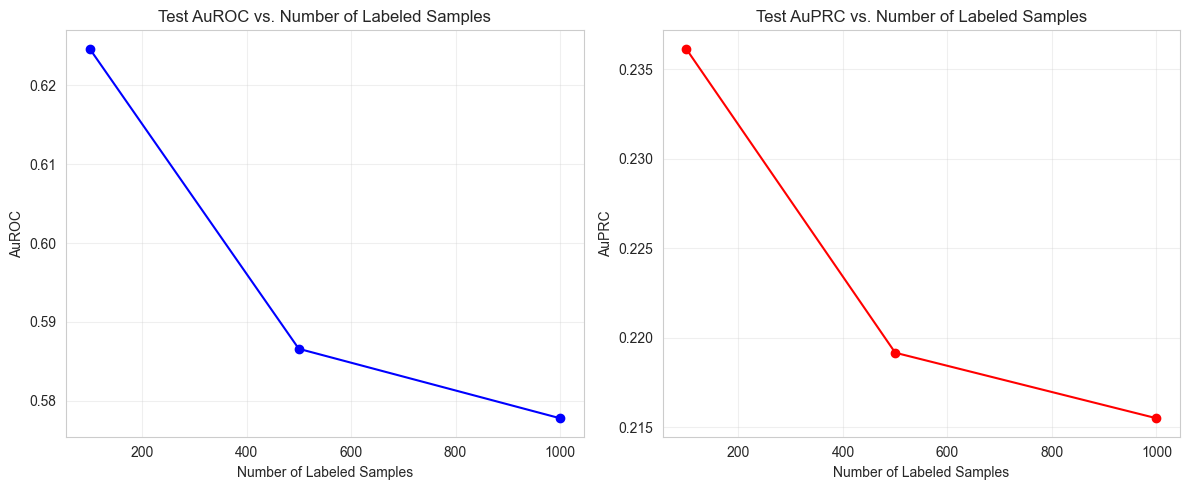

In [50]:
train_data = embedding_df_train.join(train_labels, how='inner')
X_train = train_data.drop('In-hospital_death', axis=1)
y_train = train_data['In-hospital_death']

# Sample sizes to evaluate
sample_sizes = [100, 500, 1000]
results = []

# Train and evaluate for each sample size
for n in sample_sizes:
    print(f"\nTraining with {n} labeled samples:")
    _, auc, auprc = train_linear_probe_with_limited_data(X_train, y_train, X_test, y_test, n)
    
    print(f"Test AuROC: {auc:.4f}")
    print(f"Test AuPRC: {auprc:.4f}")
    
    results.append({
        'n_samples': n,
        'AuROC': auc,
        'AuPRC': auprc
    })
results_df = pd.DataFrame(results)
print("\nResults summary:")
print(results_df)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(results_df['n_samples'], results_df['AuROC'], 'o-', color='blue')
plt.xlabel('Number of Labeled Samples')
plt.ylabel('AuROC')
plt.title('Test AuROC vs. Number of Labeled Samples')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(results_df['n_samples'], results_df['AuPRC'], 'o-', color='red')
plt.xlabel('Number of Labeled Samples')
plt.ylabel('AuPRC')
plt.title('Test AuPRC vs. Number of Labeled Samples')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('embedding_autoencoder/limited_labels_performance.png', dpi=300)
plt.show()

### Q3.3: Visualising Learned Representations (4 Pts)

We visualize the patient representations of the representation / latent space in two dimensions using t-SNE. 

In [43]:
#Generate embeddings for test set
test_embedding_dict = generate_embeddings(autoencoder, test_loader, device)
embedding_df_test = pd.DataFrame.from_dict(test_embedding_dict, orient='index')
embedding_df_test.index.name = 'RecordID'
embedding_df_test.to_csv('embedding_autoencoder/test_embeddings.csv')

test_data = embedding_df_test.join(test_labels, how='inner')
X_test = test_data.drop('In-hospital_death', axis=1)
y_test = test_data['In-hospital_death']

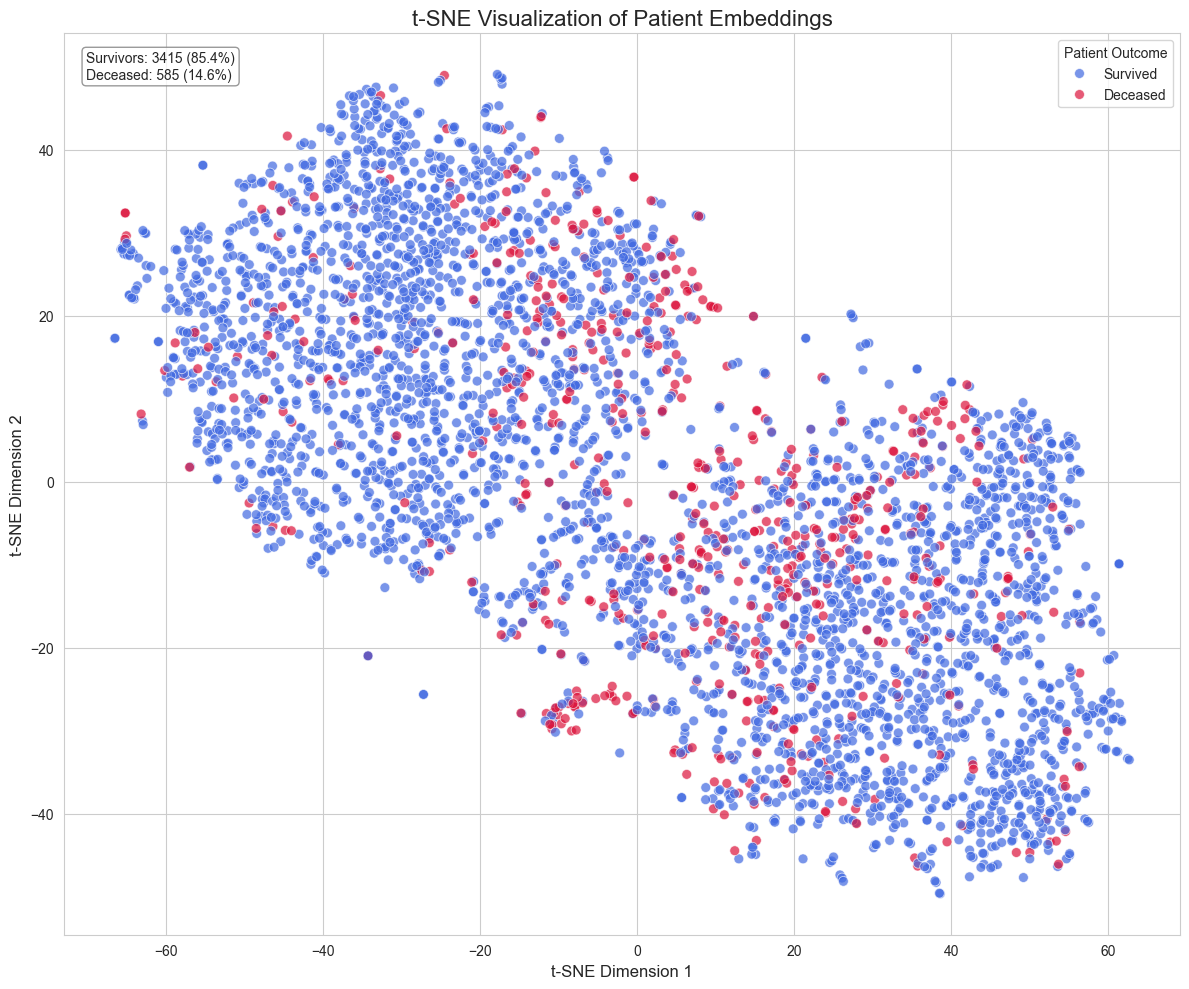

In [44]:
# t-SNE dimensionality reduction to 2 dims
tsne = TSNE(n_components=2, random_state=42, perplexity=30, max_iter=1000)
X_tsne = tsne.fit_transform(X_test.values)
tsne_df = pd.DataFrame({
    'x': X_tsne[:, 0],
    'y': X_tsne[:, 1],
    'label': y_test.values
})

# this helps for better visualization
tsne_df['label'] = tsne_df['label'].astype('category')

# different colors for labels 0 or 1
plt.figure(figsize=(12, 10))
scatter = sns.scatterplot(
    x='x', y='y',
    hue='label',
    palette={0: 'royalblue', 1: 'crimson'},
    data=tsne_df,
    alpha=0.7,
    s=50,
)

handles, labels = scatter.get_legend_handles_labels()
plt.legend(handles=handles, labels=['Survived', 'Deceased'], title='Patient Outcome')
plt.title('t-SNE Visualization of Patient Embeddings', fontsize=16)
plt.xlabel('t-SNE Dimension 1', fontsize=12)
plt.ylabel('t-SNE Dimension 2', fontsize=12)

survivors = (y_test == 0).sum()
deceased = (y_test == 1).sum()
total = len(y_test)

plt.annotate(f'Survivors: {survivors} ({survivors/total:.1%})\nDeceased: {deceased} ({deceased/total:.1%})',
             xy=(0.02, 0.98), xycoords='axes fraction',
             bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8),
             ha='left', va='top', fontsize=10)

plt.tight_layout()
plt.savefig('tsne_visualization.png', dpi=300)
plt.show()

Now, we answer the question whether data points are distributed differently for different labels.

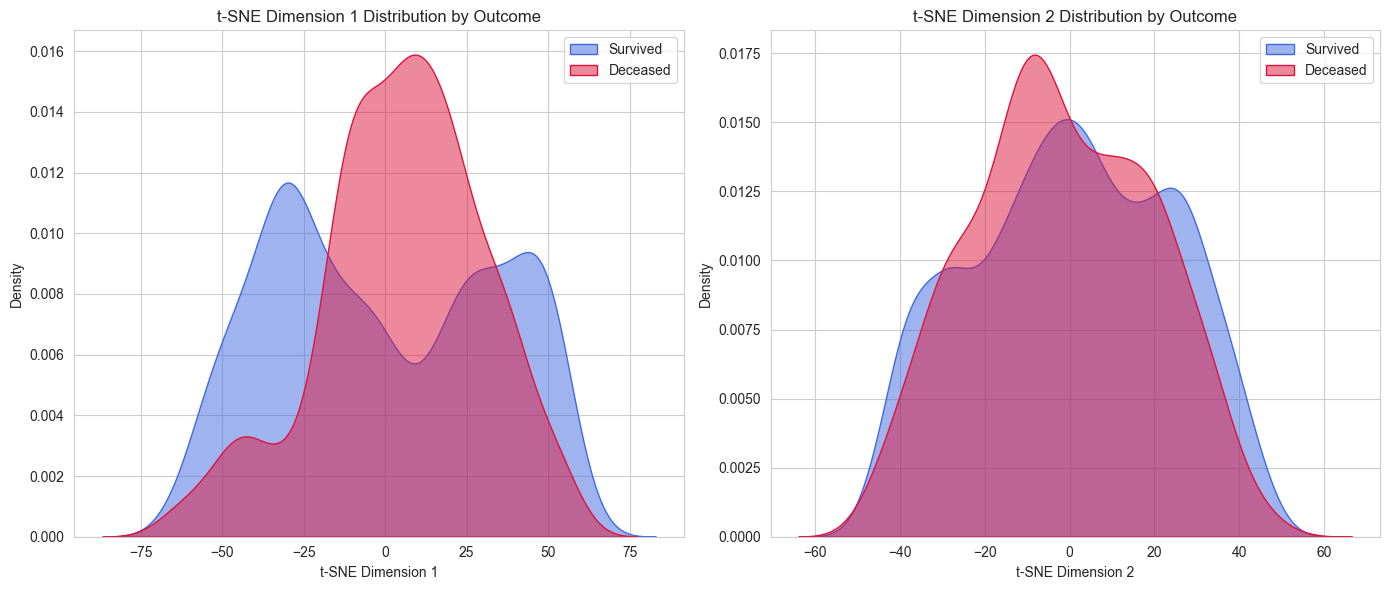

In [45]:
# Create a separate visualization with density plots for each class, two subplots for dimension 1 and 2
plt.figure(figsize=(14, 6))
for i, dim in enumerate(['x', 'y']):
    plt.subplot(1, 2, i+1)
    for label, color in zip([0, 1], ['royalblue', 'crimson']):
        subset = tsne_df[tsne_df['label'] == label]
        sns.kdeplot(subset[dim], fill=True, color=color, alpha=0.5, 
                   label='Survived' if label == 0 else 'Deceased')
    
    plt.title(f't-SNE Dimension {i+1} Distribution by Outcome')
    plt.xlabel(f't-SNE Dimension {i+1}')
    plt.ylabel('Density')
    plt.legend()

plt.tight_layout()
plt.savefig('tsne_density_by_class.png', dpi=300)
plt.show()

Next, we use a quantitative clustering metric, k-means clustering, to assess the quality of your dimensionality reduction w.r.t. target class labels. 

K=2: Silhouette Score = 0.1340, Adjusted Rand Index = 0.0055


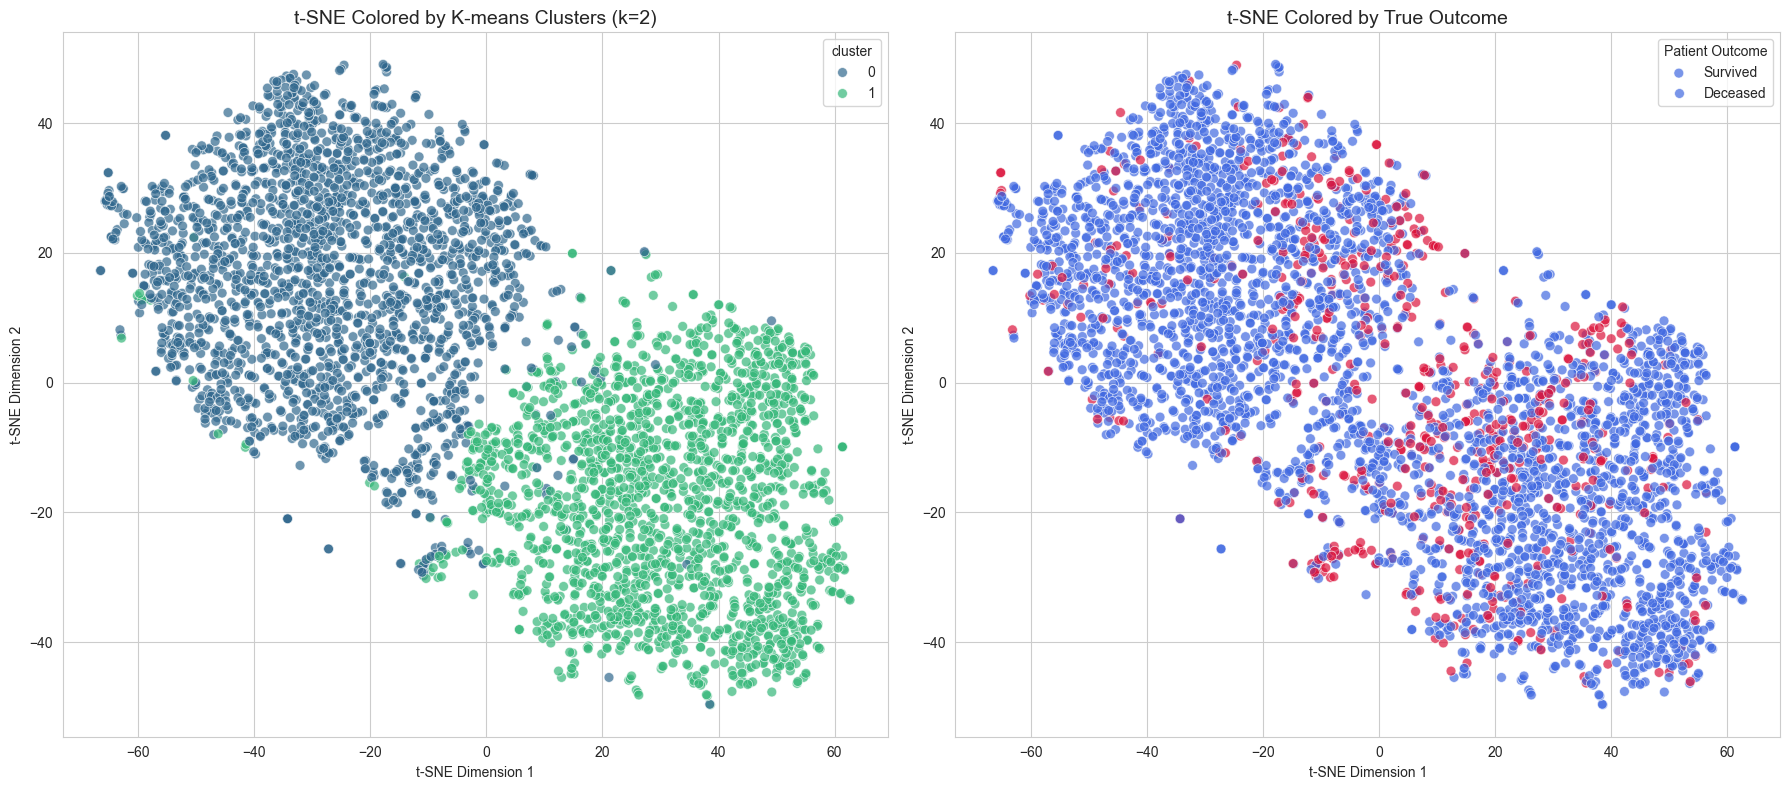

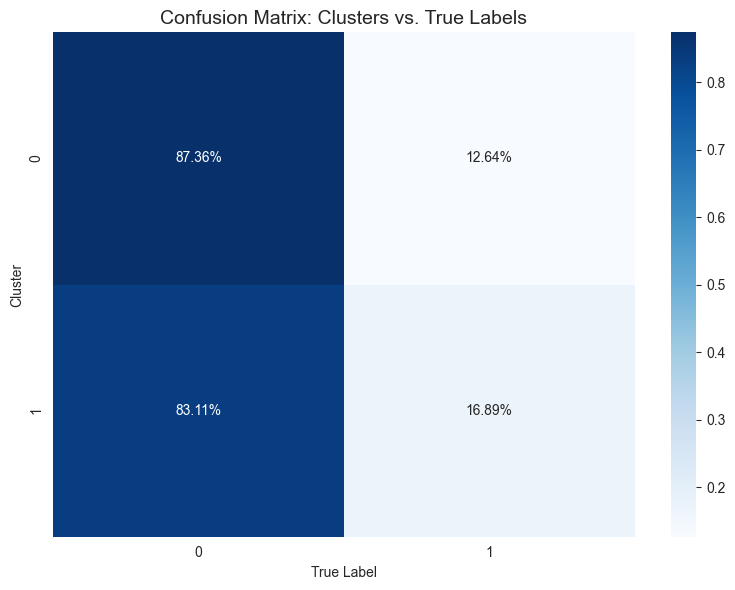

K=3: Silhouette Score = 0.1320, Adjusted Rand Index = 0.0501
K=4: Silhouette Score = 0.1269, Adjusted Rand Index = 0.0341
K=5: Silhouette Score = 0.0866, Adjusted Rand Index = 0.0229


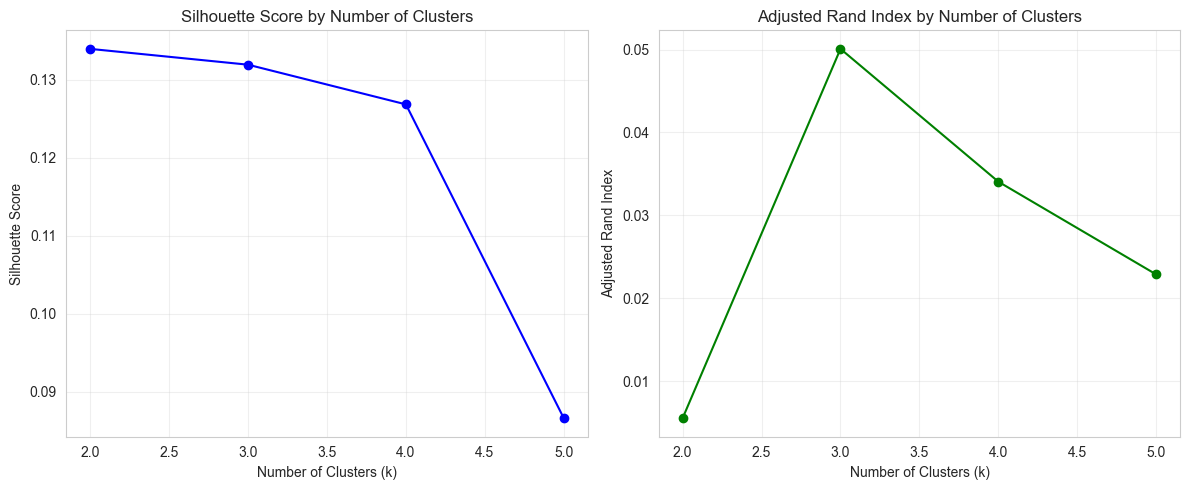

In [46]:
# Try different numbers of clusters
k_values = [2, 3, 4, 5]
silhouette_scores = []
rand_scores = []

for k in k_values:
    # Fit K-means
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    clusters = kmeans.fit_predict(X_test.values)
    
    # Calculate silhouette score
    sil_score = silhouette_score(X_test.values, clusters)
    silhouette_scores.append(sil_score)
    
    # Calculate adjusted Rand index (to compare clusters with true labels)
    rand_score = adjusted_rand_score(y_test.values, clusters)
    rand_scores.append(rand_score)
    
    print(f"K={k}: Silhouette Score = {sil_score:.4f}, Adjusted Rand Index = {rand_score:.4f}")
    
    # For k=2, visualize cluster assignments vs true labels
    if k == 2:
        # Add cluster assignments to our dataframe
        tsne_df['cluster'] = clusters
        
        # Create a visualization showing both cluster and true label
        plt.figure(figsize=(18, 8))# First plot: Color by cluster
        plt.subplot(1, 2, 1)
        sns.scatterplot(x='x', y='y', hue='cluster', data=tsne_df, palette='viridis', alpha=0.7, s=50)
        plt.title('t-SNE Colored by K-means Clusters (k=2)', fontsize=14)
        plt.xlabel('t-SNE Dimension 1')
        plt.ylabel('t-SNE Dimension 2')
        
        # Second plot: Color by true label
        plt.subplot(1, 2, 2)
        sns.scatterplot(x='x', y='y', hue='label', data=tsne_df, 
                       palette={0: 'royalblue', 1: 'crimson'}, alpha=0.7, s=50)
        plt.title('t-SNE Colored by True Outcome', fontsize=14)
        plt.xlabel('t-SNE Dimension 1')
        plt.ylabel('t-SNE Dimension 2')
        plt.legend(title='Patient Outcome', labels=['Survived', 'Deceased'])
        
        plt.tight_layout()
        plt.savefig('tsne_clusters_vs_labels.png', dpi=300)
        plt.show()
        # Create a confusion matrix between clusters and true labels
        cluster_label_df = pd.DataFrame({
            'cluster': clusters,
            'label': y_test.values
        })
        
        # Assuming cluster 0 maps to label 0 and cluster 1 to label 1
        # If not, we may need to flip the mapping
        confusion = pd.crosstab(
            cluster_label_df['cluster'], 
            cluster_label_df['label'],
            rownames=['Cluster'],
            colnames=['True Label'],
            normalize='index'  # Normalize by row for better interpretation
        )
        
        plt.figure(figsize=(8, 6))
        sns.heatmap(confusion, annot=True, cmap='Blues', fmt='.2%', cbar=True)
        plt.title('Confusion Matrix: Clusters vs. True Labels', fontsize=14)
        plt.tight_layout()
        plt.savefig('cluster_label_confusion.png', dpi=300)
        plt.show()
        
# Plot silhouette scores and adjusted Rand index for different k values
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(k_values, silhouette_scores, 'o-', color='blue')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score by Number of Clusters')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(k_values, rand_scores, 'o-', color='green')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Adjusted Rand Index')
plt.title('Adjusted Rand Index by Number of Clusters')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('clustering_metrics.png', dpi=300)
plt.show()